### Importar librerías

In [1]:
import torch

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from data_latent.dataset_mnist import obtain_mnist_dataset,concat_datasets
from utils import show_batch,save_data,latent_data_to_npy,save_model,load_model,get_data_bridge_inference
from latent_models.VAE_model.model import reparameterization_trick
from scripts_latent import train_vae
from reproducibility.reproducibility import *

%matplotlib inline


### Cargar MNIST

In [2]:
batch_size=128

rotated_train_dataset=obtain_mnist_dataset(rotation=True,min_angle=90,max_angle=90)
original_train_dataset=obtain_mnist_dataset(rotation=False)

original_train_loader = torch.utils.data.DataLoader(original_train_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=2)
rotated_train_loader = torch.utils.data.DataLoader(rotated_train_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=2)

train_loader=concat_datasets(original_train_dataset,rotated_train_dataset,batch_size,shuffle=True)


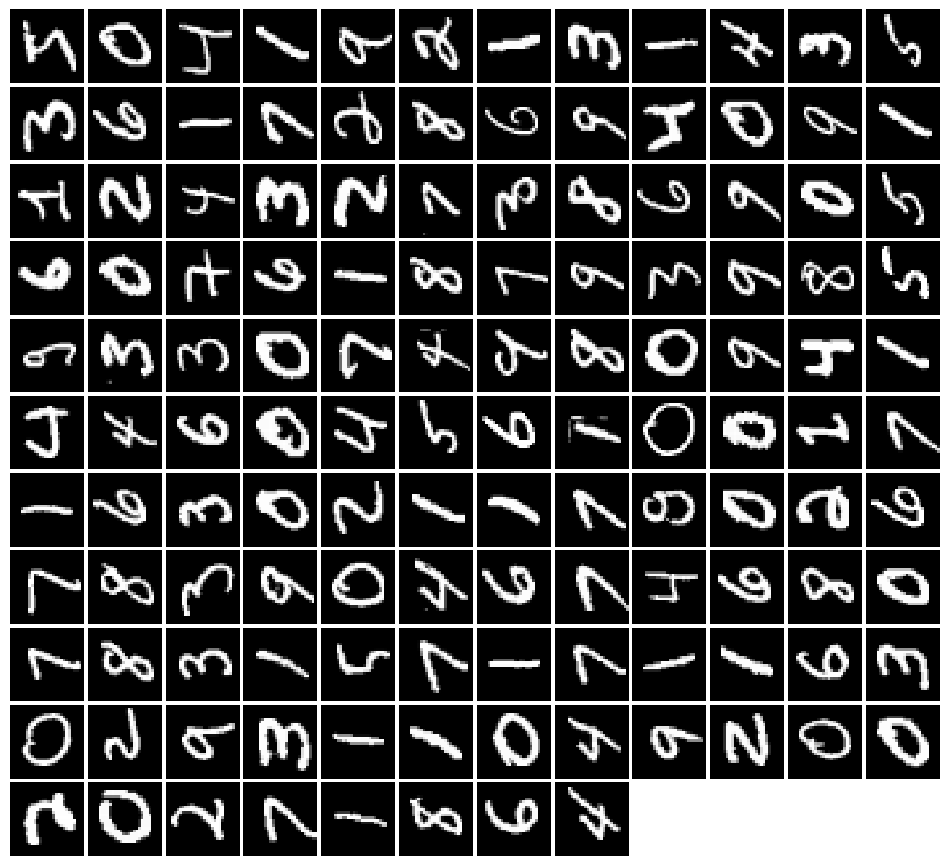

In [3]:
# Obtenemos un batch de prueba para visualizar
xb, yb = next(iter(rotated_train_loader)) # MNIST rotado 90 grados
show_batch(xb)

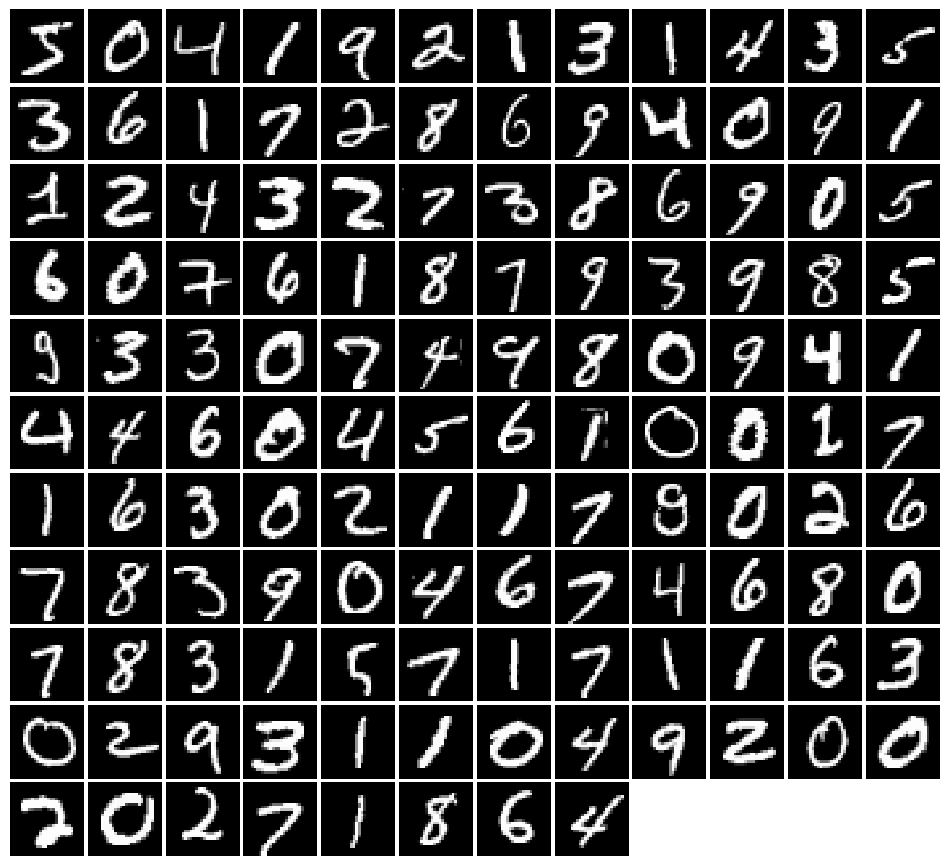

In [4]:
# Obtenemos un batch de prueba para visualizar
xb, yb = next(iter(original_train_loader)) # MNIST original
show_batch(xb)

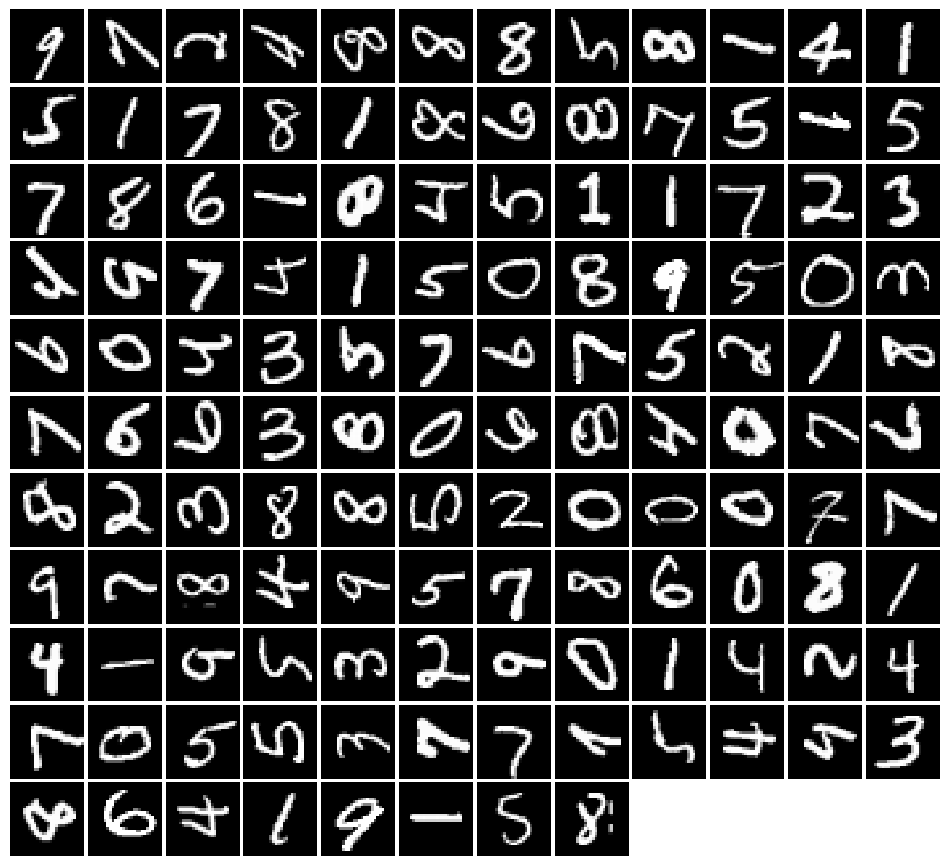

In [5]:
# Obtenemos un batch de prueba para visualizar
xb, yb = next(iter(train_loader)) #MNIST mezclado (rotado y orginal)
show_batch(xb)

### VAE

In [6]:
num_epochs = 12
input_size = 28*28
hidden_dim = 64
latent_size = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae_model=train_vae.main(train_loader,num_epochs=num_epochs,input_size=input_size,hidden_dim=hidden_dim,latent_size=latent_size,device=device)
save_model(vae_model,model_name="vae_1") # guardar modelo
#vae_model=load_model(vae_model,model_name="vae_1") # cargar modelo 

Train Epoch: 0 	Loss: 185.466568
Train Epoch: 1 	Loss: 164.331665
Train Epoch: 2 	Loss: 147.666824
Train Epoch: 3 	Loss: 135.518814
Train Epoch: 4 	Loss: 136.846863
Train Epoch: 5 	Loss: 134.366074
Train Epoch: 6 	Loss: 137.021378
Train Epoch: 7 	Loss: 131.454803
Train Epoch: 8 	Loss: 129.396957
Train Epoch: 9 	Loss: 133.628571
Train Epoch: 10 	Loss: 133.697098
Train Epoch: 11 	Loss: 125.615028


### Entrenamiento puente

Envía los datos a carpeta para entrenar puente

In [7]:
all_latent_vars_original=latent_data_to_npy(vae_model,original_train_loader,device,input_dim=28*28,model_type="VAE") # genera datos de entrenamiento VAE, este será el dataset inicial
all_latent_vars_rotated=latent_data_to_npy(vae_model,rotated_train_loader,device,input_dim=28*28,model_type="VAE") # este será el dataset final

In [8]:
data=all_latent_vars_original  # enviar datos a carpeta para entrenar el puente
save_data(data,train_prop=0.7,val_prop=0.15,time="initial")

data=all_latent_vars_rotated
save_data(data,train_prop=0.7,val_prop=0.15,time="final")

In [10]:
AlignExperiment.run("--dataset=custom_dataset  --h_dim=64  --n_layers=2  --n_epochs=10  --reg_weight=1.  --timestep_emb_dim=64  --in_dim=30 --out_dim=30  --diffusivity_schedule=constant  --max_diffusivity=.7 --use_drift_in_doobs=True  --activation=silu").save("custom_model")


Args: Namespace(data_dir='custom_dataset', log_dir='../reproducibility/custom_dataset\\model', config=None, task='synthetic', wandb_entity=None, group_name=None, wandb_mode='online', job_type='dev-train', online=False, dataset='custom_dataset', n_samples=10000, train_bs=32, val_bs=8, transform=None, split_fracs=[0.8, 0.1, 0.1], num_workers=1, in_dim=30, out_dim=30, timestep_emb_dim=64, h_dim=64, n_layers=2, activation='silu', dropout_p=0.1, run_name='jhsadfbfb', n_epochs=10, use_grad_noise=False, drift_weight=1.0, reg_weight=1.0, reg_weight_T=1.0, reg_weight_t=1.0, diffusivity_schedule='constant', max_diffusivity=0.7, use_drift_in_doobs=True, optim_name='adamw', lr=0.001, weight_decay=0.001, grad_clip_value=10.0, scheduler='plateau', scheduler_mode='min', scheduler_patience=10, ema_decay_rate=0.999, log_every=1000, eval_every=10000, inference_every=0, inference_steps=100, inference_metric='val_rmsd', inference_goal='min', early_stop_metric='val_loss', early_stop_goal='min')

Experimen

Num Train: 10000, Num Valid: 8985
Train loader inspection: tensor([ 2.4599e-03, -2.4797e-02,  1.0993e-02,  4.5962e-02,  3.9983e-03,
         1.7059e-02,  9.6786e-02,  7.8382e-02,  4.7369e-03, -5.8967e-03,
         2.5203e-03,  7.0268e-01,  5.7208e-01,  1.8522e-03, -1.5367e-01,
         9.3844e-03, -3.7396e-02, -2.4455e-02, -3.0882e+00,  7.9944e-03,
         5.2947e-03, -3.3881e+00, -3.9768e+00, -2.1527e-02,  5.0472e-04,
        -2.0827e-02, -4.9967e+00, -5.1500e+00,  1.0681e-02, -4.4332e+00])
Val loader inspection: tensor([ 2.0374e-03, -2.4746e-02,  1.1155e-02,  8.5698e-02,  3.3066e-03,
         1.6335e-02,  7.0187e-02,  8.9168e-02,  4.8882e-03, -6.8364e-03,
         3.7328e-03,  6.9442e-01,  5.2837e-01,  1.4870e-03, -2.5992e-01,
         9.3307e-03, -3.6517e-02, -2.3759e-02, -3.0877e+00,  7.4213e-03,
         5.3760e-03, -3.3950e+00, -3.9749e+00, -2.1979e-02,  1.0956e-03,
        -2.0931e-02, -4.9905e+00, -5.1460e+00,  1.0179e-02, -4.4211e+00])

Model with 0.067964M parameters

Saved 

In [11]:
bridge_model = AlignExperiment.load("custom_model") # carga modelo de puente, entrenado antes

Args: {'data_dir': 'custom_dataset', 'log_dir': '../reproducibility/custom_dataset\\model', 'config': None, 'task': 'synthetic', 'wandb_entity': None, 'group_name': None, 'wandb_mode': 'online', 'job_type': 'dev-train', 'online': False, 'dataset': 'custom_dataset', 'n_samples': 10000, 'train_bs': 32, 'val_bs': 8, 'transform': None, 'split_fracs': [0.8, 0.1, 0.1], 'num_workers': 1, 'in_dim': 30, 'out_dim': 30, 'timestep_emb_dim': 64, 'h_dim': 64, 'n_layers': 2, 'activation': 'silu', 'dropout_p': 0.1, 'run_name': 'jhsadfbfb', 'n_epochs': 10, 'use_grad_noise': False, 'drift_weight': 1.0, 'reg_weight': 1.0, 'reg_weight_T': 1.0, 'reg_weight_t': 1.0, 'diffusivity_schedule': 'constant', 'max_diffusivity': 0.7, 'use_drift_in_doobs': True, 'optim_name': 'adamw', 'lr': 0.001, 'weight_decay': 0.001, 'grad_clip_value': 10.0, 'scheduler': 'plateau', 'scheduler_mode': 'min', 'scheduler_patience': 10, 'ema_decay_rate': 0.999, 'log_every': 1000, 'eval_every': 10000, 'inference_every': 0, 'inference_st

In [12]:
data_initial=get_data_bridge_inference(folder="custom_dataset",stage="test") # obtiene datos usados en puente para hacer inferencia

In [34]:
databridge_sample=bridge_model.sample(input_data=data_initial[:20],mode="val")  # 20 samples del puente, pasa de los samples inicial a final, retorna tratyectoria del puente

#np.save('20_samples.npy', databridge_sample[-1])
#np.save('20_samples_mid.npy', databridge_sample[-50])

### Experimentos VAE

Inferencia sin pasar por puente

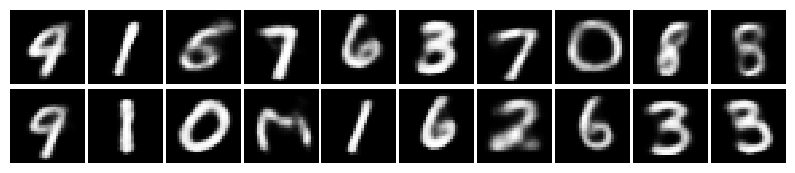

In [42]:
torch.manual_seed(2)

mus=data_initial[:20][:,:15]
log_vars=data_initial[:20][:,15:]
z=reparameterization_trick(mus, log_vars)
z=z.float().to("cpu")
samples =vae_model.decoder(z).to(device).detach()
fig = plt.figure(figsize=(10, 2))
gspec = gridspec.GridSpec(2, 10)
gspec.update(wspace=0.05, hspace=0.05)

for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28,28))

Inferencia psando por puente

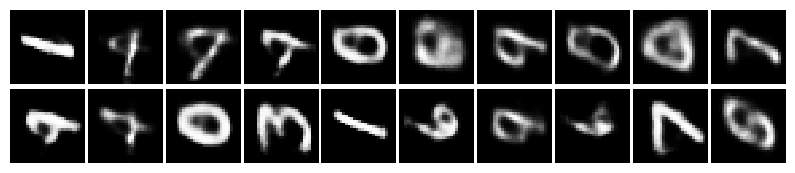

In [35]:
torch.manual_seed(2)

mus=torch.from_numpy(databridge_sample[-1][:,:15])
log_vars=torch.from_numpy(databridge_sample[-1][:,15:])
z=reparameterization_trick(mus, log_vars)
z=z.float().to("cpu")
samples =vae_model.decoder(z).to(device).detach()
fig = plt.figure(figsize=(10, 2))
gspec = gridspec.GridSpec(2, 10)
gspec.update(wspace=0.05, hspace=0.05)

for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28,28))

Inferencia pasando por la mitad del puente (trayectoria=50 de 101)

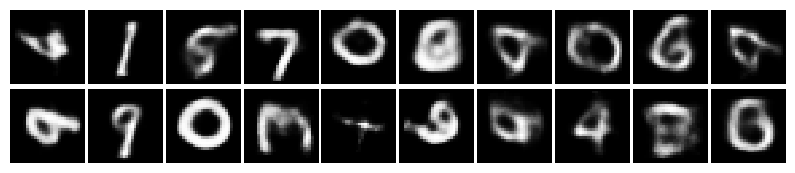

In [36]:
torch.manual_seed(2)

mus=torch.from_numpy(databridge_sample[50][:,:15])
log_vars=torch.from_numpy(databridge_sample[50][:,15:])
z=reparameterization_trick(mus, log_vars)
z=z.float().to("cpu")
samples =vae_model.decoder(z).to(device).detach()
fig = plt.figure(figsize=(10, 2))
gspec = gridspec.GridSpec(2, 10)
gspec.update(wspace=0.05, hspace=0.05)

for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28,28))

### Autoencoder

In [43]:
from scripts_latent import train_ae
num_epochs = 12
input_size = 28*28
hidden_dim = 64
latent_size = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ae_model=train_ae.main(train_loader,num_epochs=num_epochs,input_size=input_size,hidden_dim=hidden_dim,latent_size=latent_size,device=device)

Train Epoch: 0 	Loss: 0.044564
Train Epoch: 1 	Loss: 0.040396
Train Epoch: 2 	Loss: 0.033852
Train Epoch: 3 	Loss: 0.031679
Train Epoch: 4 	Loss: 0.030447
Train Epoch: 5 	Loss: 0.029523
Train Epoch: 6 	Loss: 0.028398
Train Epoch: 7 	Loss: 0.027070
Train Epoch: 8 	Loss: 0.028469
Train Epoch: 9 	Loss: 0.026579
Train Epoch: 10 	Loss: 0.027530
Train Epoch: 11 	Loss: 0.024512


Genera datos para entrenar puente

In [47]:
all_latent_vars_original=latent_data_to_npy(ae_model,original_train_loader,device,input_dim=28*28,model_type="AE")
all_latent_vars_rotated=latent_data_to_npy(ae_model,rotated_train_loader,device,input_dim=28*28,model_type="AE")

In [48]:
data=all_latent_vars_original

save_data(data,train_prop=0.7,val_prop=0.15,time="initial")

data=all_latent_vars_rotated
save_data(data,train_prop=0.7,val_prop=0.15,time="final")

### Entrenar puente para Autoencoder

In [49]:
AlignExperiment.run("--dataset=custom_dataset  --h_dim=64  --n_layers=2  --n_epochs=10  --reg_weight=1.  --timestep_emb_dim=64  --in_dim=15 --out_dim=15  --diffusivity_schedule=constant  --max_diffusivity=.7 --use_drift_in_doobs=True  --activation=silu").save("custom_model_ae")


Args: Namespace(data_dir='custom_dataset', log_dir='../reproducibility/custom_dataset\\model', config=None, task='synthetic', wandb_entity=None, group_name=None, wandb_mode='online', job_type='dev-train', online=False, dataset='custom_dataset', n_samples=10000, train_bs=32, val_bs=8, transform=None, split_fracs=[0.8, 0.1, 0.1], num_workers=1, in_dim=15, out_dim=15, timestep_emb_dim=64, h_dim=64, n_layers=2, activation='silu', dropout_p=0.1, run_name='zrqdhzgtm', n_epochs=10, use_grad_noise=False, drift_weight=1.0, reg_weight=1.0, reg_weight_T=1.0, reg_weight_t=1.0, diffusivity_schedule='constant', max_diffusivity=0.7, use_drift_in_doobs=True, optim_name='adamw', lr=0.001, weight_decay=0.001, grad_clip_value=10.0, scheduler='plateau', scheduler_mode='min', scheduler_patience=10, ema_decay_rate=0.999, log_every=1000, eval_every=10000, inference_every=0, inference_steps=100, inference_metric='val_rmsd', inference_goal='min', early_stop_metric='val_loss', early_stop_goal='min')

Experimen

In [50]:
bridge_model = AlignExperiment.load("custom_model_ae")

Args: {'data_dir': 'custom_dataset', 'log_dir': '../reproducibility/custom_dataset\\model', 'config': None, 'task': 'synthetic', 'wandb_entity': None, 'group_name': None, 'wandb_mode': 'online', 'job_type': 'dev-train', 'online': False, 'dataset': 'custom_dataset', 'n_samples': 10000, 'train_bs': 32, 'val_bs': 8, 'transform': None, 'split_fracs': [0.8, 0.1, 0.1], 'num_workers': 1, 'in_dim': 15, 'out_dim': 15, 'timestep_emb_dim': 64, 'h_dim': 64, 'n_layers': 2, 'activation': 'silu', 'dropout_p': 0.1, 'run_name': 'zrqdhzgtm', 'n_epochs': 10, 'use_grad_noise': False, 'drift_weight': 1.0, 'reg_weight': 1.0, 'reg_weight_T': 1.0, 'reg_weight_t': 1.0, 'diffusivity_schedule': 'constant', 'max_diffusivity': 0.7, 'use_drift_in_doobs': True, 'optim_name': 'adamw', 'lr': 0.001, 'weight_decay': 0.001, 'grad_clip_value': 10.0, 'scheduler': 'plateau', 'scheduler_mode': 'min', 'scheduler_patience': 10, 'ema_decay_rate': 0.999, 'log_every': 1000, 'eval_every': 10000, 'inference_every': 0, 'inference_st

In [51]:
data_initial=get_data_bridge_inference(folder="custom_dataset",stage="test") # carga los datos para pasarle al puente

In [53]:
databridge_sample=bridge_model.sample(input_data=data_initial[:20],mode="val")  # 20 samples (inferencia del puente con el autoencoder)

#np.save('databridge_sample.npy', databridge_sample[-1])
#np.save('databridge_sample.npy', databridge_sample[-50])

### Experimentos autoencoder

Datos normales, sin usar el puente

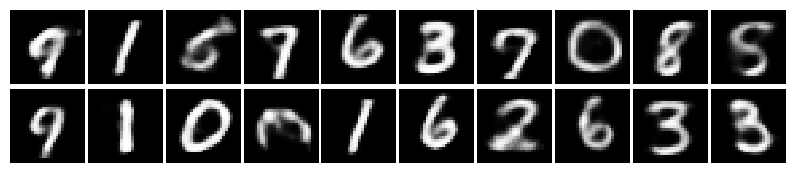

In [57]:
z=data_initial[:20]
z=z.float().to("cpu")
samples =ae_model.decoder(z).to(device).detach()
fig = plt.figure(figsize=(10, 2))
gspec = gridspec.GridSpec(2, 10)
gspec.update(wspace=0.05, hspace=0.05)

for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28,28))

Utilizando el puente 

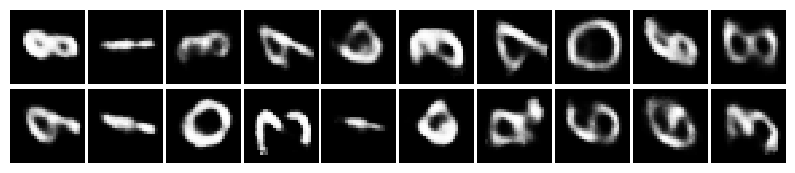

In [58]:
z=torch.from_numpy(databridge_sample[-1])
z=z.float().to("cpu")
samples =ae_model.decoder(z).to(device).detach()
fig = plt.figure(figsize=(10, 2))
gspec = gridspec.GridSpec(2, 10)
gspec.update(wspace=0.05, hspace=0.05)

for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28,28))

Utilizando la mitad de la trayectoria del puente

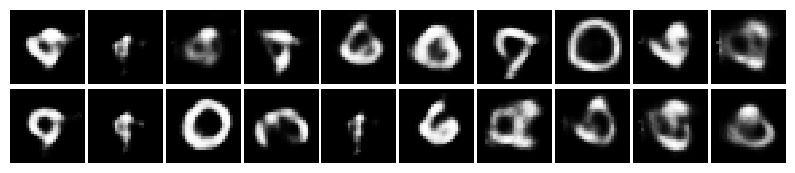

In [59]:
z=torch.from_numpy(databridge_sample[50])
z=z.float().to("cpu")
samples =ae_model.decoder(z).to(device).detach()
fig = plt.figure(figsize=(10, 2))
gspec = gridspec.GridSpec(2, 10)
gspec.update(wspace=0.05, hspace=0.05)

for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28,28))